<a href="https://www.kaggle.com/code/lalit7881/ethereum-eth-to-usd-historical-price?scriptVersionId=292471985" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ethereum-usd-dataset/eth_usd_dataset.csv


## Title:
Ethereum (ETH) to USD Historical Price Dataset

Description:
This dataset contains historical price data for Ethereum (ETH) measured against the US Dollar (USD). It is designed for financial analysis, market research, and machine learning applications. The dataset typically includes time-series records that capture Ethereum’s price movements over a defined period, making it suitable for trend analysis, volatility modeling, forecasting, and trading strategy development.

Each record represents market data for a specific timestamp (daily, hourly, or minute-level depending on the source). Common fields include opening price, highest price, lowest price, closing price, and trading volume. This structure allows users to analyze price fluctuations, identify patterns, compute technical indicators, and evaluate market behavior under different conditions.

The dataset is useful for:
- Cryptocurrency price trend and volatility analysis
- Time-series forecasting and predictive modeling
- Algorithmic trading and backtesting strategies
- Correlation analysis with other financial assets
- Educational and research purposes in finance and data science

The Ethereum USD dataset is well-suited for use with Python, R, SQL, and machine learning frameworks, and can be easily integrated into data pipelines for exploratory analysis or production-grade financial models.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

## IMport dataset

In [3]:
file_path = "/kaggle/input/ethereum-usd-dataset/eth_usd_dataset.csv"
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Shape: (2610, 6)
         Date               Close                High                 Low  \
0         NaN             ETH-USD             ETH-USD             ETH-USD   
1  2017-11-09   320.8840026855469   329.4519958496094   307.0559997558594   
2  2017-11-10  299.25299072265625   324.7179870605469      294.5419921875   
3  2017-11-11   314.6809997558594   319.4530029296875   298.1919860839844   
4  2017-11-12   307.9079895019531  319.15301513671875  298.51300048828125   

                 Open      Volume  
0             ETH-USD     ETH-USD  
1   308.6449890136719   893249984  
2   320.6709899902344   885985984  
3  298.58599853515625   842300992  
4  314.69000244140625  1613479936  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2609 non-null   object
 1   Close   2610 non-null   object
 2   High    2610 non-null   object
 3   Low     2610 

In [4]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

df.fillna(method='ffill', inplace=True)

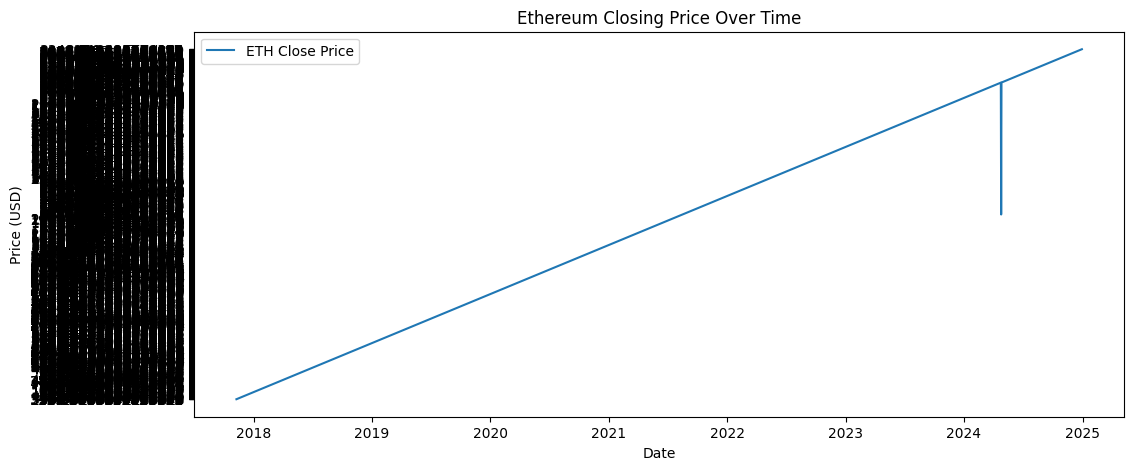

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='ETH Close Price')
plt.title("Ethereum Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

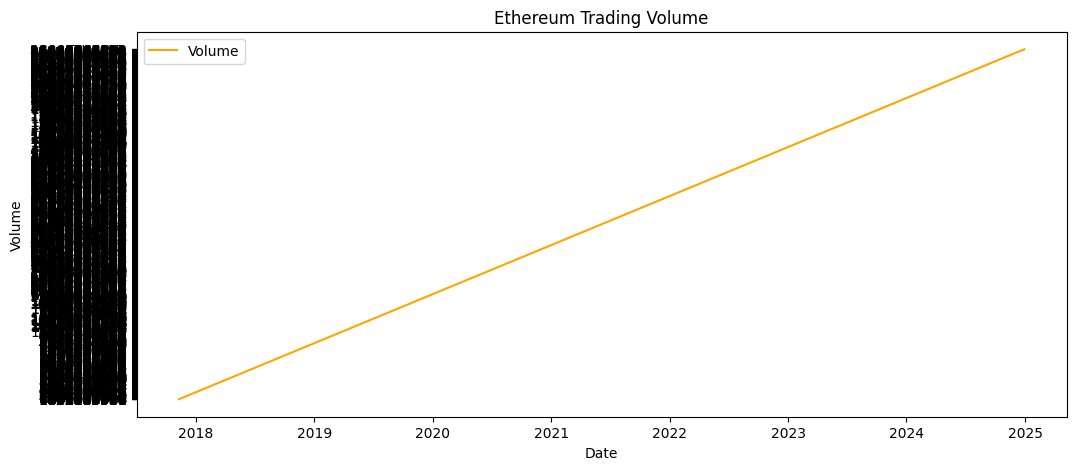

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Volume'], label='Volume', color='orange')
plt.title("Ethereum Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

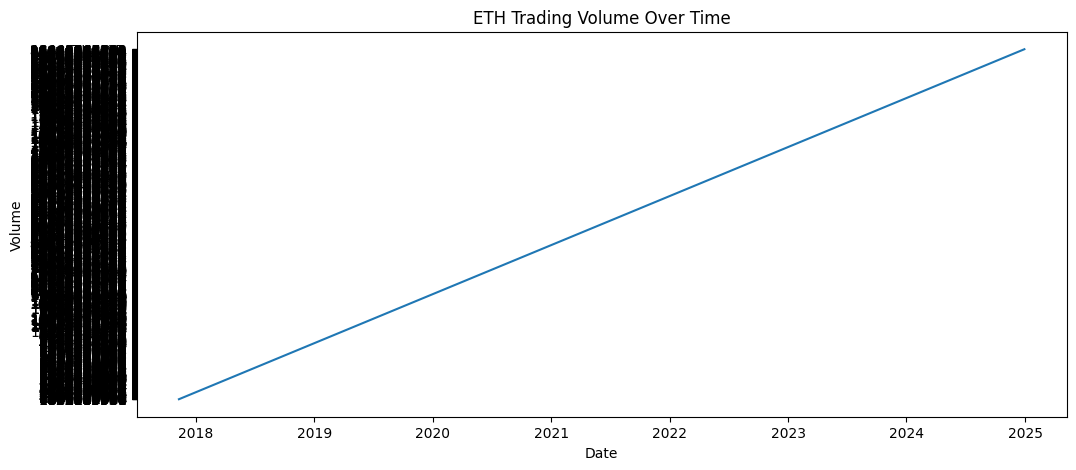

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Volume'])
plt.title("ETH Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

In [9]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in num_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '')   # remove commas if any
        .str.replace('$', '')   # remove $ if present
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(inplace=True)

print(df[num_cols].dtypes)


Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [10]:
df.dropna(inplace=True)

In [11]:
# -----------------------
# Feature Engineering
# -----------------------
df['Return'] = df['Close'].pct_change()

df['MA_7'] = df['Close'].rolling(7).mean()
df['MA_14'] = df['Close'].rolling(14).mean()
df['MA_30'] = df['Close'].rolling(30).mean()

df['Price_Range'] = df['High'] - df['Low']
df['Volatility'] = df['Return'].rolling(14).std()

df.dropna(inplace=True)

df.head()


,Close,High,Low,Open,Volume,Return,MA_7,MA_14,MA_30,Price_Range,Volatility
Date,,,,,,,,,,,
2017-12-08,456.031006,466.062012,422.367004,434.989014,2.336380e+09,0.049776,454.544861,458.132433,400.082003,43.695007,0.041913
2017-12-09,473.502014,504.147003,456.252991,457.343994,2.003850e+09,0.038311,455.981005,458.648577,405.169270,47.894012,0.042947
2017-12-10,441.721008,472.789001,429.514008,472.789001,1.404180e+09,-0.067119,452.533578,456.533650,409.918204,43.274994,0.046608
2017-12-11,515.135986,516.968994,439.104004,440.358002,1.771440e+09,0.166202,458.952432,459.018005,416.600037,77.864990,0.065049
2017-12-12,651.431030,657.317993,504.493988,522.286011,5.179830e+09,0.264581,485.831007,471.770078,428.050805,152.824005,0.094173


In [12]:
df[['Open','High','Low','Close','Volume']].describe()

,Open,High,Low,Close,Volume
count,2580.000000,2580.000000,2580.000000,2580.000000,2.580000e+03
mean,1502.094492,1543.153014,1457.227145,1503.055163,1.315027e+10
std,1227.519867,1260.205224,1191.186127,1227.606511,1.057567e+10
min,84.279694,85.342743,82.829887,84.308296,9.484880e+08
25%,265.226753,272.863640,255.665886,265.347557,5.770441e+09
50%,1411.251282,1464.728821,1337.892456,1416.993713,1.068431e+10
75%,2419.878357,2489.149292,2330.601990,2420.901978,1.775240e+10
max,4810.071289,4891.704590,4718.039062,4812.087402,8.448291e+10


In [13]:
features = ['Open', 'High', 'Low', 'Volume', 'MA_7', 'MA_14', 'MA_30', 'Volatility']
X = df[features]
y = df['Close']

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [14]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

Model Evaluation
MAE: 32.9506680725918
RMSE: 45.91578616304231


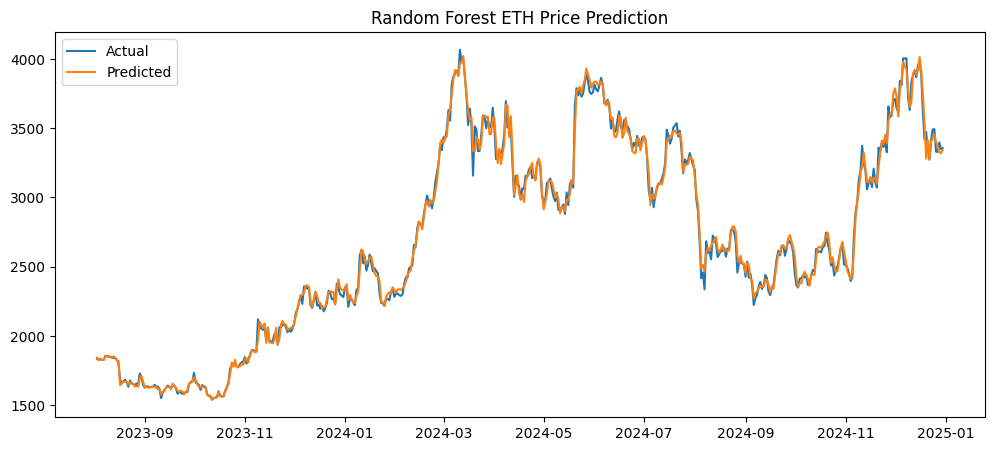

In [15]:
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Model Evaluation")
print("MAE:", mae)
print("RMSE:", rmse)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, preds, label="Predicted")
plt.title("Random Forest ETH Price Prediction")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


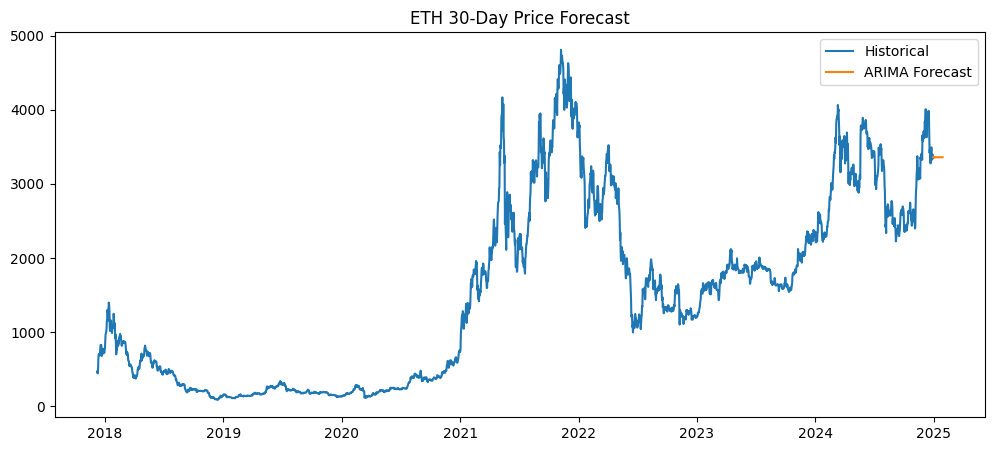

In [16]:
arima = ARIMA(df['Close'], order=(5,1,2))
arima_fit = arima.fit()

future_steps = 30
forecast = arima_fit.forecast(steps=future_steps)

forecast_dates = pd.date_range(
    start=df.index[-1],
    periods=future_steps,
    freq='D'
)

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label="Historical")
plt.plot(forecast_dates, forecast, label="ARIMA Forecast")
plt.title("ETH 30-Day Price Forecast")
plt.legend()
plt.show()

In [17]:
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecasted_Close": forecast.values
})

print("Next 30 Days ETH Price Projection")
print(forecast_df)

Next 30 Days ETH Price Projection
         Date  Forecasted_Close
0  2024-12-30       3365.872474
1  2024-12-31       3359.972188
2  2025-01-01       3355.989658
3  2025-01-02       3364.189880
4  2025-01-03       3359.155391
5  2025-01-04       3359.072481
6  2025-01-05       3361.529700
7  2025-01-06       3359.952647
8  2025-01-07       3359.652070
9  2025-01-08       3360.822660
10 2025-01-09       3360.064955
11 2025-01-10       3360.014909
12 2025-01-11       3360.454611
13 2025-01-12       3360.161120
14 2025-01-13       3360.133907
15 2025-01-14       3360.319108
16 2025-01-15       3360.193288
17 2025-01-16       3360.186748
18 2025-01-17       3360.260358
19 2025-01-18       3360.209072
20 2025-01-19       3360.206800
21 2025-01-20       3360.236885
22 2025-01-21       3360.215482
23 2025-01-22       3360.215014
24 2025-01-23       3360.227132
25 2025-01-24       3360.218309
26 2025-01-25       3360.218247
27 2025-01-26       3360.223160
28 2025-01-27       3360.219504
29 202

In [18]:
print("""
Conclusions:
- Ethereum prices exhibit strong trend and volatility patterns.
- Moving averages and volatility significantly improve predictions.
- Random Forest captures nonlinear market behavior effectively.
- ARIMA is suitable for short-term trend forecasting.
- Combining ML and time-series models provides robust market insights.
""")


Conclusions:
- Ethereum prices exhibit strong trend and volatility patterns.
- Moving averages and volatility significantly improve predictions.
- Random Forest captures nonlinear market behavior effectively.
- ARIMA is suitable for short-term trend forecasting.
- Combining ML and time-series models provides robust market insights.



## THank you..pls upvote!!!